# Vehicle Detection and Tracking

In [36]:
# Import all required modules
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from collections import deque
import time
%matplotlib inline

In [37]:
# Read all the test images
test_images = []
fnames = glob.glob('./test_images/test*.jpg')

for fname in fnames:
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)

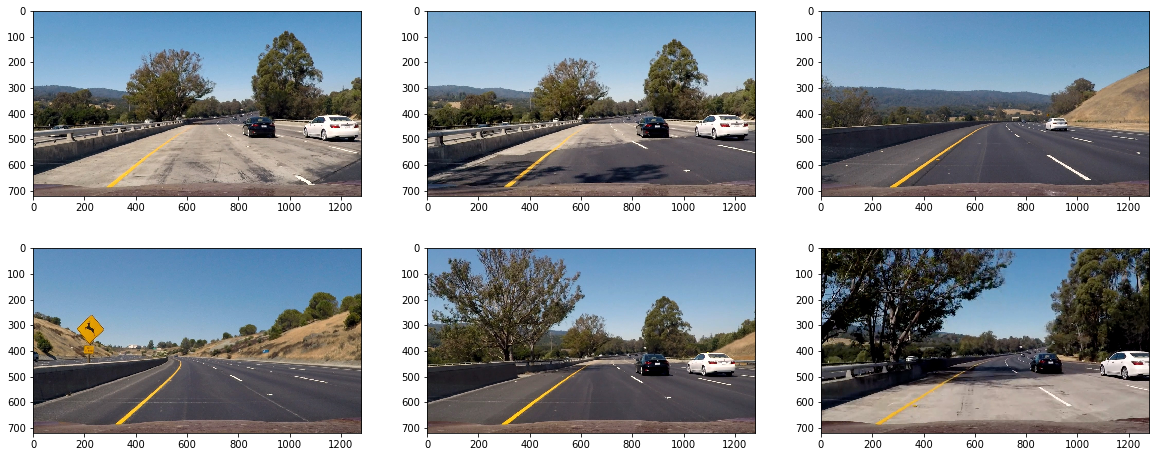

In [38]:
# Setting up a function to plot test images from a list like above
def plot_images(image_list, cmap = 'gray'):
    rows = 2
    cols = 3
    f,ax = plt.subplots(rows,cols,figsize=(20,int(13*rows/cols)))
    for i in range(len(image_list)):
        image = image_list[i]
        ax[int(i/cols),i%cols].imshow(image, cmap = cmap)

# TEST
plot_images(test_images)

## Feature extraction

#### 1. HOG features

In [39]:
# Getting hog features, works only on single color channel image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#### 2. Spatial features

In [40]:
# Getting spatial features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

#### 3. Color histogram features

In [41]:
# Getting color histogram features
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#### 4. Combining all features

In [42]:
# Defining a function to extract features from a list of image paths to 
# create a list of feature vectors
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel='ALL', orient=9, pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = cv2.cvtColor(image, eval('cv2.COLOR_RGB2'+cspace))
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Apply get_hog_features() 
        if hog_channel == 'ALL': #This can be 0, 1, 2 or 'ALL'
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

#### 5. Feature scaling

In [43]:
# Defining a function that uses StandardScaler on the feature vectors 
# to scale them to zero mean and unit variance
def scale_features(features): # features is an output list from extract features
    # Create an array stack of feature vectors
    X = np.vstack((features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Return the scaled feature vectors
    return scaled_X, X_scaler

##  Classification of cars and non-cars 

#### 1. Forming data for supervised learning

In [44]:
# Using the car_features and notcar_features, we form a dataset with labels that can be used for training an SVC
# car images have label 1 and notcar images have label 0
def form_data(car_features, notcar_features):
    feature_vectors = np.vstack((car_features, notcar_features)).astype(np.float64)
    feature_vectors, scaler = scale_features(feature_vectors)
    labels = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return feature_vectors, labels, scaler

#### 2. Training and validating an SVM classifier

In [45]:
# Training and validating an SVC to classify cars and non-cars in an image 
def train_and_validate(feature_vectors, labels):
    # Shuffle the data
    feature_vectors, labels = shuffle(feature_vectors, labels)
    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.2, random_state=42)
    # Using a LinearSVC
    clf = LinearSVC()
    # Training time for SVC
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t,2), 'Seconds to train SVC...')
    # Checking the accuracy score of the SVC
    print('Test accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    return clf 

#### 3. Find cars in an image using sliding windows, hog subsampling and a trained SVM classifier

In [46]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        ctrans_tosearch = cv2.cvtColor(img_tosearch, eval('cv2.COLOR_RGB2'+cspace))
    else: 
        ctrans_tosearch = img_tosearch

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Storing the positive detection bounding boxes
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(box)
                
    return draw_img, bbox_list

## Removing false positives and multiple detections

#### 1. Generate heatmap images using positive detections

In [47]:
# Generating heatmap images to remove false positives and multiple detections
# using bounding box list obtained from find_cars() function
def add_heat(image, bbox_list):
    # Initializing heatmap with the same size as the image 
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    # Iterating through list of boxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return the heatmap
    return heatmap

#### 2. Apply threshold to limit false positives

In [48]:
# Applying thresholding to reject areas of false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

#### 3. Label hot regions as separate detections

In [49]:
# Determining which box belongs to which car by identifying the number of 
# hot detections in the heatmap
from scipy.ndimage.measurements import label
def separate_hots(heatmap):
    labels = label(heatmap)
    return labels

#### 4. Single function that takes in an image and returns the seperated hot regions

In [50]:
# get_labels() takes in an image, applies heatmap thresholding, aggregates hot regions and returns the separated hot regions
def get_labels(image, cspace, ystart, ystop, scales, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold):
    bbox_list = []
    for scale in scales:
        img, bboxes = find_cars(image, cspace, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = bbox_list + bboxes
    heatmap = add_heat(image, bbox_list)
    heatmap = apply_threshold(heatmap, heat_threshold)
    labels = separate_hots(heatmap)
    return labels

#### 7. Drawing a bounding box around the hot regions

In [51]:
# Drawing bounding boxes around the thresholded detections
def draw_labeled_boxes(img, labels):
    # iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Testing the functions on still images

#### 1. Read in the image paths which we'll use for training an SVC

In [52]:
# Reading the car and not-car images 
# Non vehicle images
notcar_image_paths1 = glob.glob('./data/non-vehicles/Extras/extra*.png')
notcar_image_paths2 = glob.glob('./data/non-vehicles/GTI/image*.png')

# Vehicle images
car_image_paths1 = glob.glob('./data/vehicles/KITTI_extracted/*.png')
car_image_paths2 = glob.glob('./data/vehicles/GTI_Far/image*.png')
car_image_paths3 = glob.glob('./data/vehicles/GTI_Left/image*.png')
car_image_paths4 = glob.glob('./data/vehicles/GTI_MiddleClose/image*.png')
car_image_paths5 = glob.glob('./data/vehicles/GTI_Right/image*.png')

#### 2. Define all the required parameters

In [53]:
# Defining the parameters
cspace = 'YCrCb'
ystart = 350
ystop = 700
scales = [1, 1.5, 2]
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
hog_channel = 'ALL' # Can be 0, 1, 2 or 'ALL'

# Vehicles and non-vehicle images
non_vehicles = notcar_image_paths1 + notcar_image_paths2
vehicles = car_image_paths1 + car_image_paths2 + car_image_paths3 + car_image_paths4 + car_image_paths5 

#### 3. Extract features from training data and train an SVC

In [54]:
# Extract car and non-car features
t0 = time.time()
car_features = extract_features(vehicles, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                                hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
noncar_features = extract_features(non_vehicles, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                                hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
t1 = time.time()
# Form data set
# Scale feature vectors and store the scaler
feature_vectors, labels, scaler = form_data(car_features, noncar_features)
t2 = time.time()
# Train and Validate an SVC
svc = train_and_validate(feature_vectors, labels)
t3 = time.time()

print(round(t1-t0, 2),'Seconds to extract features from training data...')
print(round(t2-t1, 2),'Seconds to format data for supervised learning...')

22.33 Seconds to train SVC...
Test accuracy of SVC =  0.9938
71.27 Seconds to extract features from training data...
18.74 Seconds to format data for supervised learning...


#### 4. Detect all car classes

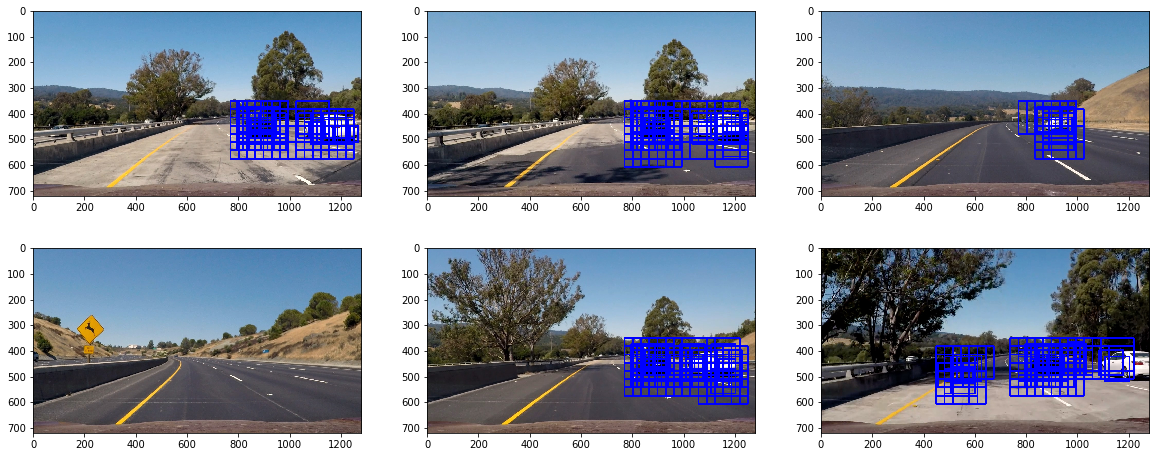

In [55]:
# Storing images where cars are found by the find_cars() function
detection_images = []

# Iterating over all test images
for image in test_images:
    # Iterating over different scales for sliding windows
    for scale in scales:
        # find_cars will return detection image as well as coordinates for the bounding boxes from positive detections
        image, bbox_list = find_cars(image, cspace, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    detection_images.append(image)

# Plotting detection images
plot_images(detection_images)

#### 5. Creating heatmap images

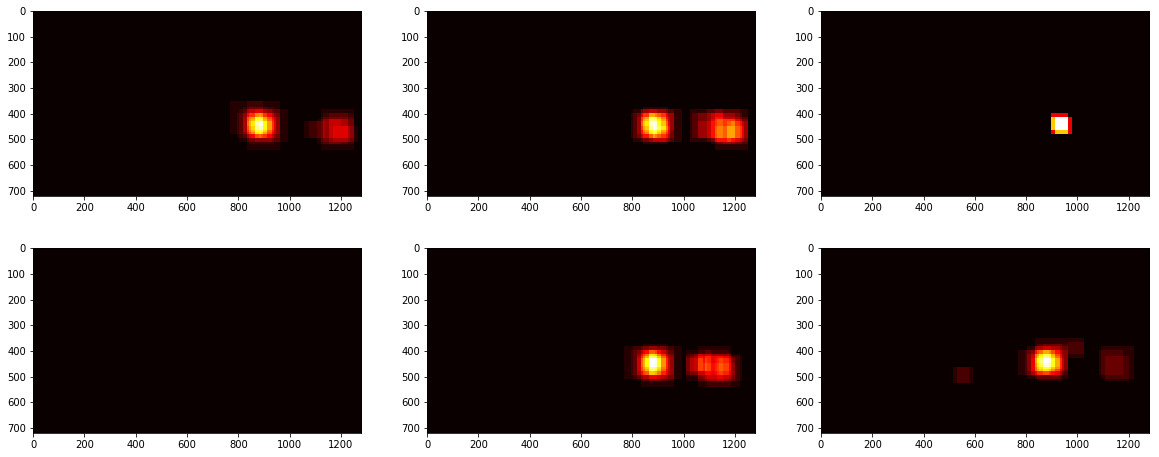

In [56]:
# Storing heatmap images
heatmap_images = []

# Iterating over the test images
for image in test_images:
    # Getting detection using find_cars
    bbox_list = []
    for scale in scales:
        img, bboxes = find_cars(image, cspace, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = bbox_list + bboxes
    # Getting heatmap image
    heatmap_image = add_heat(image, bbox_list)
    # Appedning to the list
    heatmap_images.append(heatmap_image)
    
# Plot heatmap images
plot_images(heatmap_images, cmap = 'hot')

#### 6. Thresholding heatmaps to remove false positives

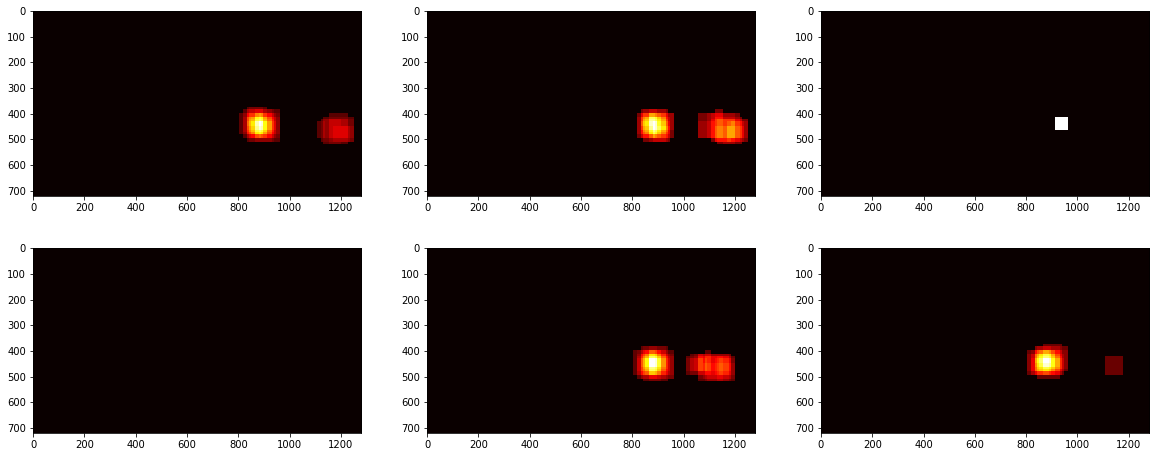

In [57]:
# Storing the thresholded heatmaps
thresholded = []

# Iterating over the test images
for heatmap in heatmap_images:
    # using apply_threshold on the heatmap and append the returned image to the list
    thresholded.append(apply_threshold(heatmap, 2))
    
# Plotting the thresholded heatmaps
plot_images(thresholded, cmap = 'hot')

#### 7. Labeling hot regions

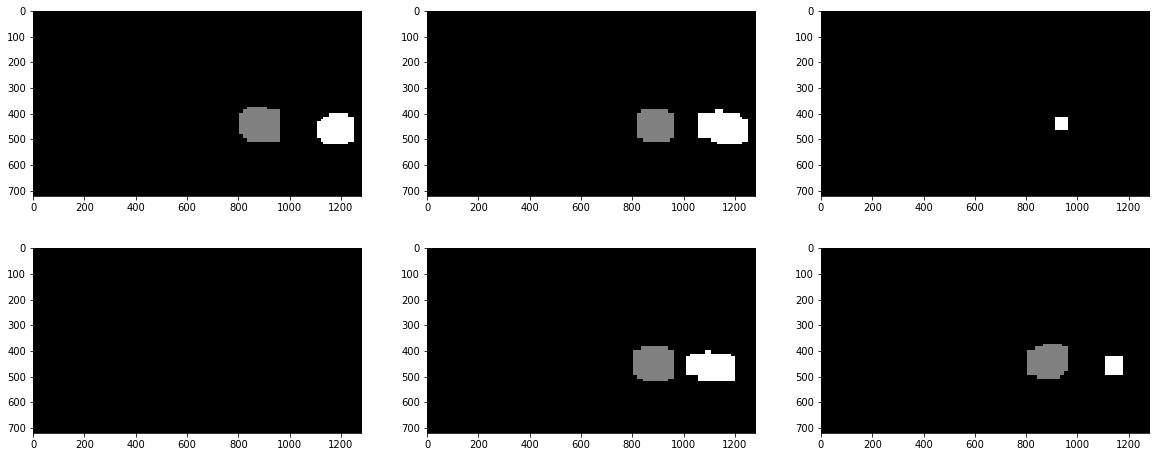

In [58]:
# Storing images where the hot regions are separated using labels (in the form of different colored pixels)
labeled_images = []

# Parameter
heat_threshold = 2

# Iterating over the test images
for image in test_images:
    # get_labels returns the labeled image and the number of detected hot regions
    labels = get_labels(image, cspace, ystart, ystop, scales, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold)
    # labels[0] is where we can find the labeled image
    labeled_images.append(labels[0])

# Plot the labeled images
plot_images(labeled_images)

#### 8. Bounding boxes around labeled regions

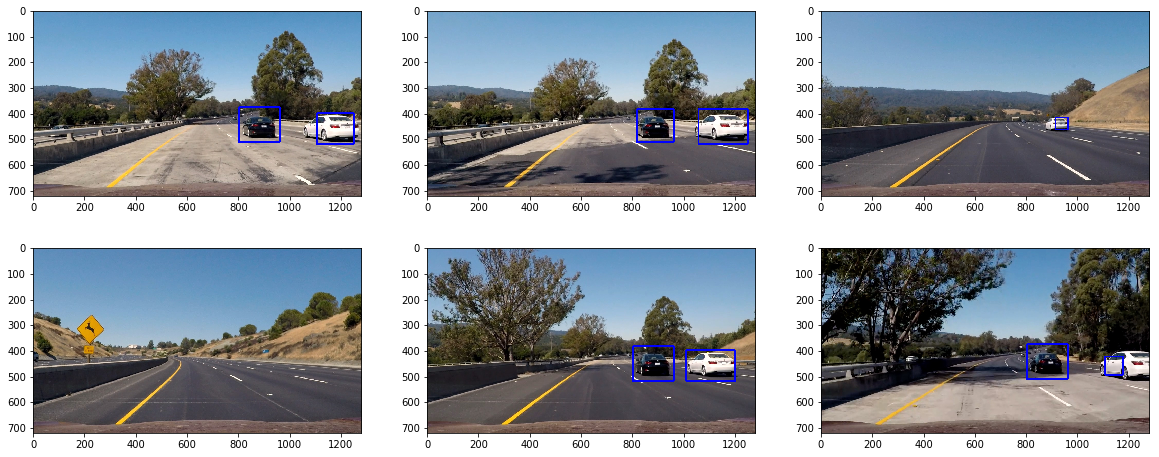

In [59]:
# Storing the images
hot_detections = []

# Iterating over test images
for image in test_images:
    # Get labels
    labels = get_labels(image, cspace, ystart, ystop, scales, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold)
    # Draw labeled boxes
    hot_detection = draw_labeled_boxes(image, labels)
    # Append to the list of images
    hot_detections.append(hot_detection)
    
# Plot hot detection
plot_images(hot_detections)    

## Modifying for Video input 

#### 1. Modifying the get_labels() function to perform heatmap thresholding over a number of consecutive frames for better and stable detection

In [60]:
# heatmap_array stores the heatmaps of a fixed number of continuous frames
# !! REMEMBER to reinitialize this everytime a new video is used
heatmap_array = deque(maxlen=10)

In [61]:
# Modified get_labels() that uses heatmap thresholding of a fixed number of consecutive frames
def get_labels(image, cspace, ystart, ystop, scales, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold):
    # calling in the heatmap_array where we store 10 consecutive frames' heatmaps
    global heatmap_array
    # empty array to store the positive detections of current frame
    bbox_list = []
    # iterating over different scales
    for scale in scales:
        # finding car detections
        img, bboxes = find_cars(image, cspace, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # adding the positive detections to the array
        bbox_list = bbox_list + bboxes
    # heatmap from this image
    current_heatmap = add_heat(image, bbox_list)
    # appending this heatmap to the recent heatmaps, heatmap_array
    heatmap_array.append(current_heatmap)
    # taking the sum of recent heatmaps
    heatmap_sum = sum(heatmap_array)
    # applyinh thresholds such that false positives can be removed
    heatmap = apply_threshold(heatmap_sum, heat_threshold)
    # getting 
    labels = separate_hots(heatmap)
    # return the labels
    return labels

## Using the complete pipeline on Video input 

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Read in training data

In [63]:
# Reading the car and not-car images 
# Non vehicle images
notcar_image_paths1 = glob.glob('./data/non-vehicles/Extras/extra*.png')
notcar_image_paths2 = glob.glob('./data/non-vehicles/GTI/image*.png')

# Vehicle images
car_image_paths1 = glob.glob('./data/vehicles/KITTI_extracted/*.png')
car_image_paths2 = glob.glob('./data/vehicles/GTI_Far/image*.png')
car_image_paths3 = glob.glob('./data/vehicles/GTI_Left/image*.png')
car_image_paths4 = glob.glob('./data/vehicles/GTI_MiddleClose/image*.png')
car_image_paths5 = glob.glob('./data/vehicles/GTI_Right/image*.png')

In [64]:
# Vehicles and non-vehicle images
non_vehicles = notcar_image_paths1 + notcar_image_paths2
vehicles = car_image_paths1 + car_image_paths2 + car_image_paths3 + car_image_paths4 + car_image_paths5 

#### Parameters for training

In [67]:
# Defining the parameters
cspace = 'YCrCb'
ystart = 350
ystop = 700
scales = [1, 1.5, 2]
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32
hist_range = (0, 256)
hog_channel = 'ALL' # Can be 0, 1, 2 or 'ALL'
heat_threshold = 25

#### Train an SVC for identifying cars 

In [68]:
# Extract car and non-car features
t0 = time.time()
car_features = extract_features(vehicles, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                                hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
print('We have', len(car_features), 'car and...')

noncar_features = extract_features(non_vehicles, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                                hog_channel=hog_channel, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
print(len(noncar_features), 'non car datapoints')

print('with the following characteristics...')
print('Shape of each image:', cv2.imread(vehicles[0]).shape)
print('Feature vector length:', len(car_features[0]))

t1 = time.time()
# Form data set
# Scale feature vectors and store the scaler
feature_vectors, labels, scaler = form_data(car_features, noncar_features)
t2 = time.time()
# Train and Validate an SVC
svc = train_and_validate(feature_vectors, labels)
t3 = time.time()

print(round(t1-t0, 2),'Seconds to extract features from training data...')
print(round(t2-t1, 2),'Seconds to format data for supervised learning...')

We have 8792 car and...
8968 non car datapoints
with the following characteristics...
Shape of each image: (64, 64, 3)
Feature vector length: 8460
45.25 Seconds to train SVC...
Test accuracy of SVC =  0.9918
76.53 Seconds to extract features from training data...
16.53 Seconds to format data for supervised learning...


#### Process image and find cars in the video

In [69]:
def process_image(image):
    # Defining the parameters
    cspace = 'YCrCb'
    ystart = 350
    ystop = 700
    scales = [1, 1.5, 2]
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32,32)
    hist_bins = 32
    hist_range = (0, 256)
    hog_channel = 'ALL' # Can be 0, 1, 2 or 'ALL'
    heat_threshold = 25
    # Get labeled images
    labels = get_labels(image, cspace, ystart, ystop, scales, svc, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold)
    # Draw boxes over labels
    out = draw_labeled_boxes(image, labels)
    return out

In [71]:
# Read in a video, detect cars for each frame and return a video with detected cars
output = 'project_video_solved.mp4'
# !! REMEMBER to reinitialize this everytime a new video is used
heatmap_array = deque(maxlen=10)
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_solved.mp4
[MoviePy] Writing video project_video_solved.mp4


100%|█████████▉| 1260/1261 [41:26<00:01,  1.95s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solved.mp4 

CPU times: user 43min 22s, sys: 11 s, total: 43min 33s
Wall time: 41min 27s
